# Photo Query Assistant on Azure

This notebook describes solution to implement a sample solution to query photos stored on Azure.

You'll learn how to create and manage Azure resources such as Azure Storage and Cosmos DB, upload photos and metadata using Python scripts, retrieve photos based on text queries using embeddings, and deploy an Azure Function to query photos via HTTP requests.

## Prerequisites

1. **Azure Subscription**: Obtain an Azure subscription to create and manage cloud services.
2. **Install Azure CLI**: Install Azure CLI to manage Azure resources from the command line.
3. **Azure Storage Account**: Set up an Azure Storage account to store photos and metadata securely.
4. **Python Environment**: Install Python, create a new Conda environment, and install necessary dependencies for Azure CLI, Azure Cosmos, Azure Blob Storage, and additional required packages.
5. **PyCharm or Similar IDE**: Set up an IDE like PyCharm for Python development and project management.

### Tips

- **Choose Region Wisely**: Select the region for resource deployment carefully to optimize performance and compliance.
- **Enable Data Lake Storage Gen2**: Consider [enabling](https://learn.microsoft.com/en-us/azure/storage/blobs/create-data-lake-storage-account) Data Lake Storage Gen2 capabilities for the storage account to enhance scalability and capabilities.
- **Utilize Azure Data Factory**: For efficient data ingestion and periodic data transfer, evaluate Azure Data Factory as a potential solution.



## Create a Container in Azure Data Lake

### Implementation

*   Open a command prompt or terminal.
*   Run the following commands to create a container in your storage account.

```bash
az storage container create --name myphotos --account-name <your-storage-account-name> --account-key <your-storage-account-key>
```

*   Replace `<your-storage-account-name>` and `<your-storage-account-key>` with the values from your storage account.

### Generate connection string

* Go to your storage account in the Azure Portal.
* Navigate to "Shared access signature" under the "Security and networking.
* Configure the SAS token settings (permissions, start and expiry time, allowed services, etc.).
* Click "Generate SAS and connection string".
* Copy the relevant values to the .env file `photo_assistant.env`.

File `photo_assistant.env` is used here to store keys and relevant environment variables. Its structure is as follows:

```bash
AZURE_STORAGE_CONNECTION_STRING="<replace-with-your-value>"
BLOB_CONTAINER_NAME="photos"
COSMOS_ENDPOINT="<replace-with-your-value>"
COSMOS_KEY="<replace-with-your-value>"
COSMOS_DATABASE_NAME="<replace-with-your-value>"
COSMOS_CONTAINER_NAME="<replace-with-your-value>"
EMBEDDING_MODEL_PATH="openai/clip-vit-base-patch32"
EMBEDDING_PROCESSOR_PATH="openai/clip-vit-base-patch32"
```

## Create Azure Cosmos DB Account

### Prerequisites

* Familiarize yourself with new feature of [Vector Search](https://learn.microsoft.com/en-us/azure/cosmos-db/nosql/vector-search).

### Implementation

* Go to the Azure Portal.
* Navigate to "Cosmos DB" and click "Create".
* Select NoSQL Cosmos DB.
* Fill in the required fields.
* Click "Review + create" and then "Create".

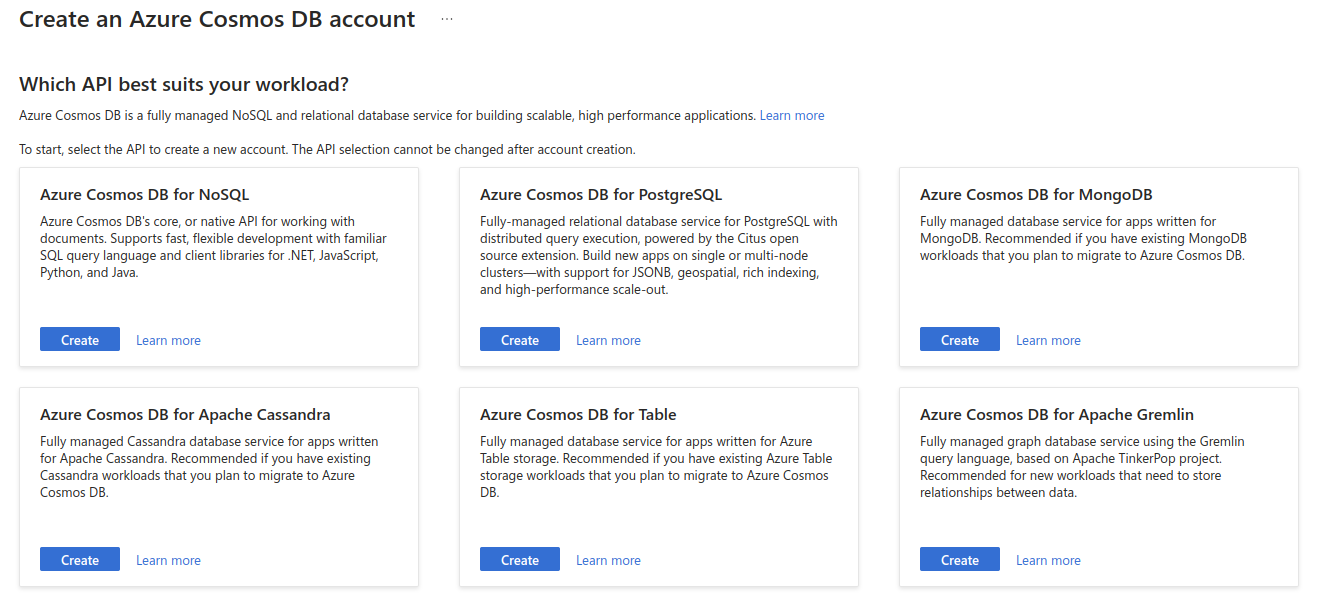

Create a Database and Container after the account is created.
* [Enable](https://learn.microsoft.com/en-us/azure/cosmos-db/nosql/vector-search#enroll-in-the-vector-search-preview-feature) feature of Vector Search.
* Click on "Data Explorer" and then "New Container".
* Create a new database (e.g., PhotoDatabase).
* Within the database, create a new container (e.g., PhotoMetadata). **Important** - make sure to specify Container Vector Policy, as those can no longer be edited after Container creation.

* Set the partition key to /photoId.

## Upload Photos and Metadata via Python Script

### Prerequisites

1. Install and create a new conda environment.
2. Install necessary dependencies (azure cli, azure cosmos, blob storage, torch and transformer packages).
3. Install PyCharm and create a new project with existing conda environment.

### Implementation

Use the script `upload_photos_and_metadata.py`.  After running it, you should observe that your storage container will have the test photos uploaded, and the Cosmos DB will as well have the corresponding items with the metadata stored.

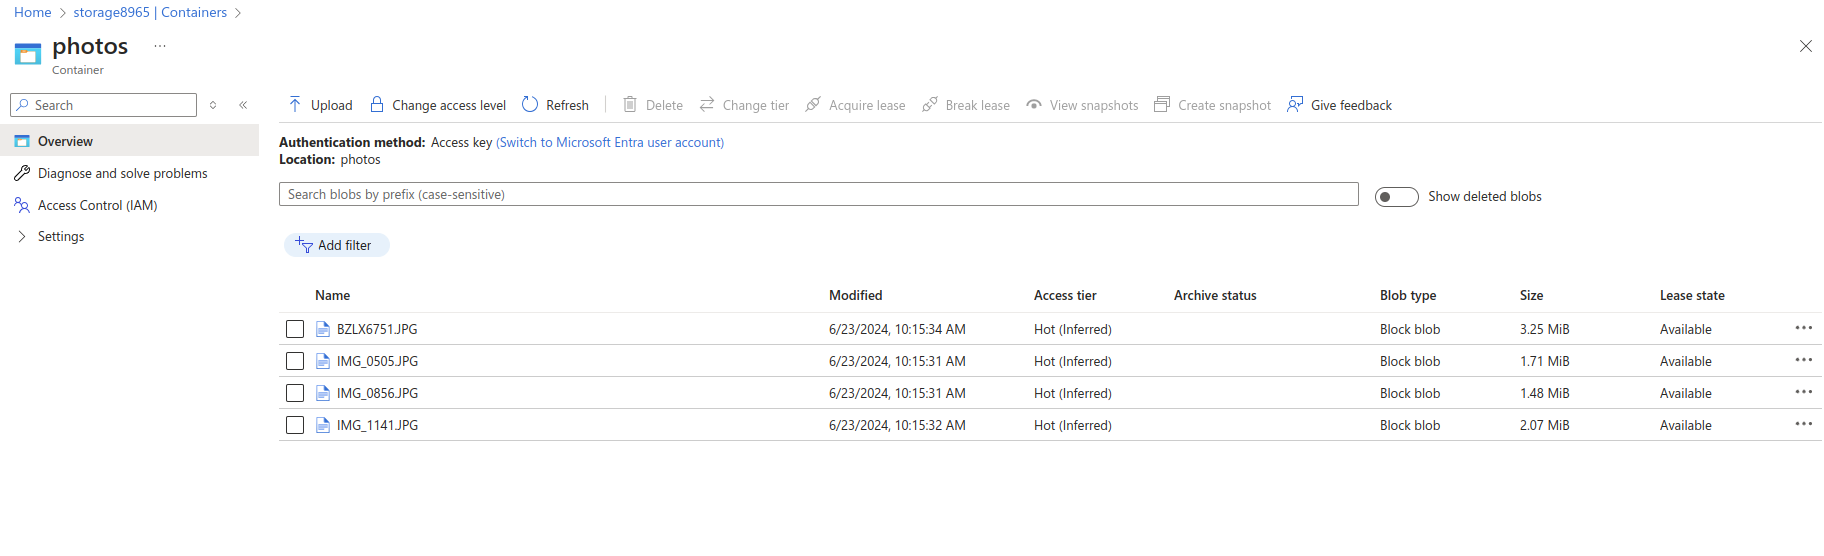

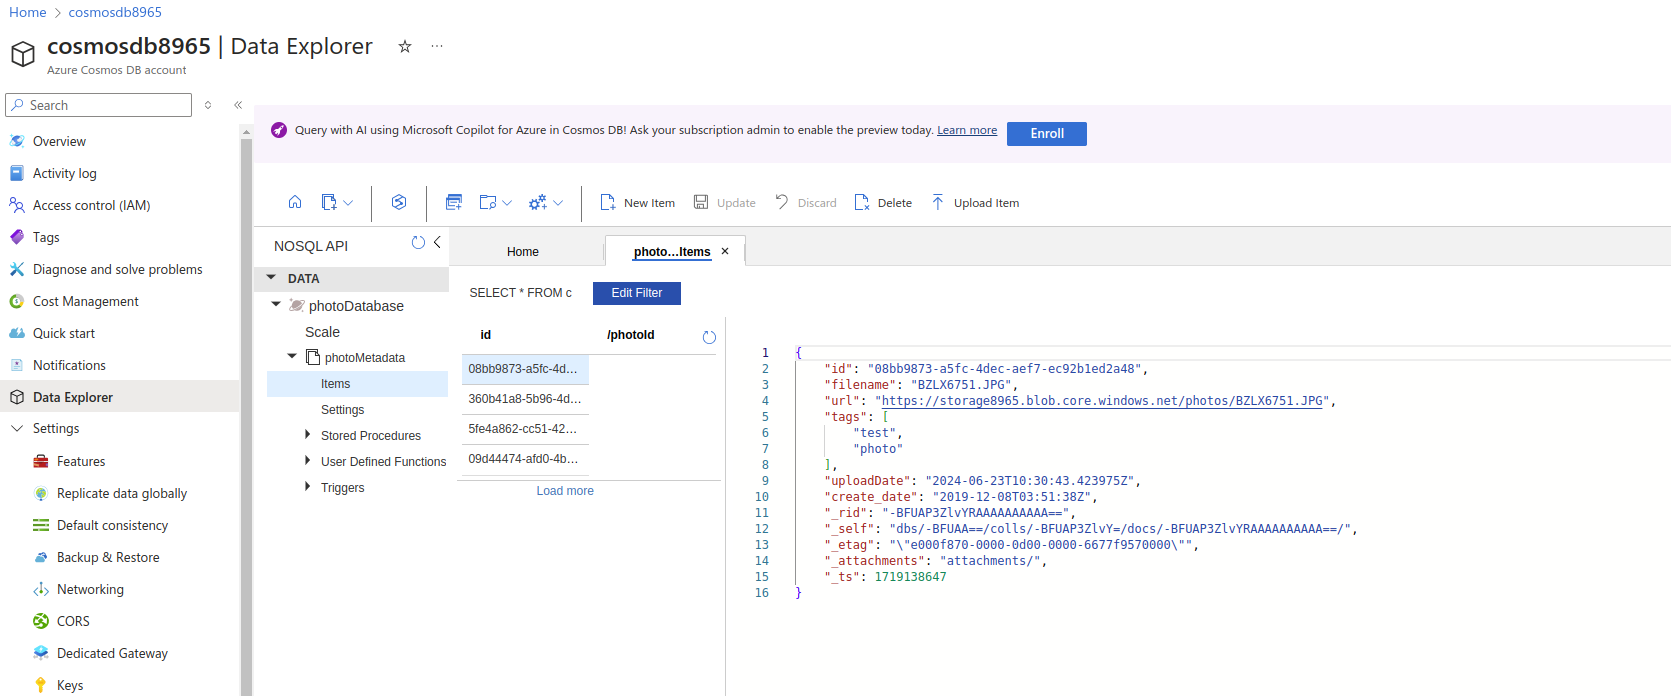

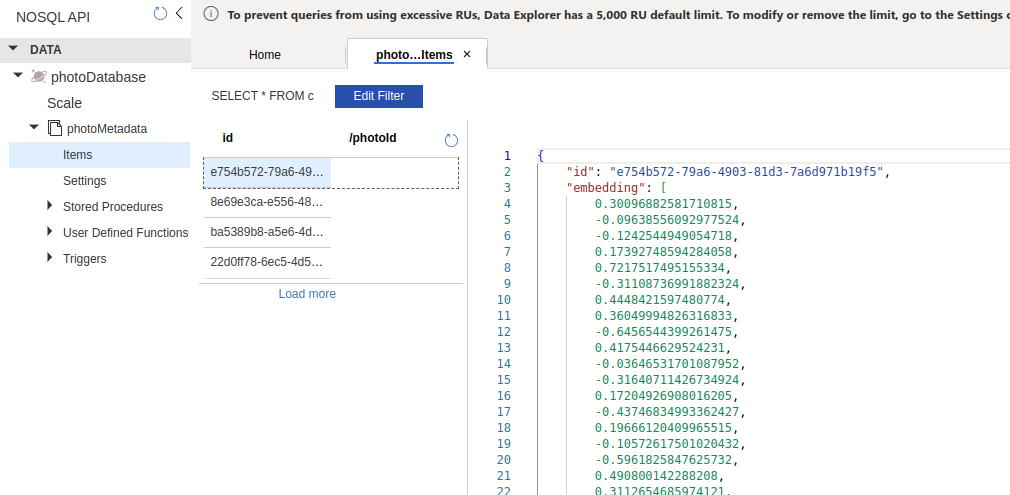

## Retrieve Photo

### Prerequisites


*   Familiriaze yourself with basics of vector search (see [Azure documentation](https://learn.microsoft.com/en-us/azure/cosmos-db/nosql/how-to-python-vector-index-query#running-vector-similarity-search-query)).


### Implementation

Now, we will leverage our stored metadata to retrieve relevant photos based on a text query. This approach allows us to efficiently find and display photos that match specific textual descriptions using embeddings generated by the CLIP model.

To achieve this, we will:

1. Generate an embedding for the query text using the CLIP model.
2. Fetch all photo embeddings from Azure Cosmos DB. *
3. Calculate the cosine similarity between the query embedding and each photo embedding. *
4. Identify and returns the photo with the highest similarity score.

*) Note that points 2 and 3 are alternative to using the vector seacrh capabilities (method `find_closest_match_by_vector_search`).

For detailed implementation, refer to the `retrieve_photos.py` script.

By executing the script, we expect to see that the closest matches returned are the right ones, corresponding accurately to each query.

By checking the results for the following queries, we can validate the correctness of the closest match.
- `Closest photo ID: 3e8626ec-622e-4cb2-b03b-c32ba16966d8 with similarity: 0.25718275388931044 for the query: photo with flowers` (correct)
- `Closest photo ID: 4e355754-caf3-436f-b29f-3d70c0967344 with similarity: 0.24154892574563916 for the query: photo with food` (correct)
- `Closest photo ID: c23cab28-53cd-4058-bc79-03ca680ae218 with similarity: 0.20231598624678526 for the query: photo with portrait` (correct)
- `Closest photo ID: 8bb5ac92-f533-4b49-a16d-9e05d78602ae with similarity: 0.23582351560957632 for the query: photo with city` (correct)

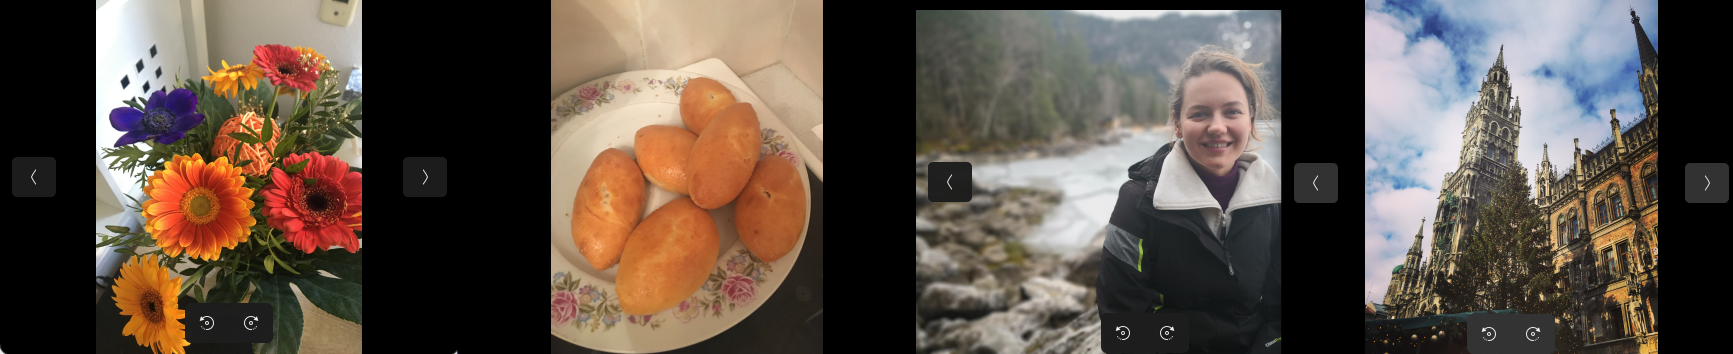



## Retrieve Photo with Azure Function

Azure Function App is a serverless compute service that allows you to run event-triggered code without having to explicitly provision or manage infrastructure.

We can utilize the Azure Functions to create a microservice that responds to HTTP requests to retrieve photos stored in the cloud.

### Prerequsites

* Azure Functions Core Tools installed.
* Azure Function App created (see [instructions](https://learn.microsoft.com/en-us/azure/azure-functions/functions-create-function-app-portal?pivots=programming-language-python)).

In [ ]:
# Function app and storage account names must be unique.

# Variable block
location="westeurope"
resourceGroup="storage-rg"
tag=""
storage="storage8965"
functionApp="PhotoQueryFunctionApp"
skuStorage="Standard_LRS"
functionsVersion="4"
pythonVersion="3.10"

# Create a serverless python function app in the resource group.
echo "Creating $functionApp"
az functionapp create --name $functionApp --storage-account $storage --consumption-plan-location "$location" --resource-group $resourceGroup --os-type Linux --runtime python --runtime-version $pythonVersion --functions-version $functionsVersion

### Implementation

Follow these steps to set up the Azure Function for querying photos.

* Initialize the Azure Function project. Open your terminal and run the command

```bash
func init PhotoQueryFunction --worker-runtime python --model V2
```

* Create a new HTTP trigger function by running the command

```bash
func new --name QueryPhoto --template "HTTP trigger" --authlevel anonymous
```
* Modify the `local.settings.json` file to include necessary configuration values that are crucial for connecting to Azure services. For local testing, set `"AzureWebJobsStorage": "UseDevelopmentStorage=true"`


In [ ]:
{
  "IsEncrypted": false,
  "Values": {
    "FUNCTIONS_WORKER_RUNTIME": "python",
    "AzureWebJobsFeatureFlags": "EnableWorkerIndexing",
    "AzureWebJobsStorage": "UseDevelopmentStorage=true",
    "AZURE_STORAGE_CONNECTION_STRING": "Your_Azure_Storage_Connection_String",
    "BLOB_CONTAINER_NAME": "photos",
    "COSMOS_ENDPOINT": "Your_Cosmos_DB_Endpoint",
    "COSMOS_KEY": "Your_Cosmos_DB_Key",
    "COSMOS_DATABASE_NAME": "photoDatabase",
    "COSMOS_CONTAINER_NAME": "photoMetadata",
    "EMBEDDING_MODEL_PATH": "openai/clip-vit-base-patch32",
    "EMBEDDING_PROCESSOR_PATH": "openai/clip-vit-base-patch32"
  },
  "Host": {
    "LocalHttpPort": 7071,
    "CORS": "*",
    "CORSCredentials": false
  }
}


* Run the function locally by executing the command

```bash
func start
```

This will start the function app locally, making it available for HTTP requests on port 7071 at the address http://localhost:7071/api/QueryPhoto.

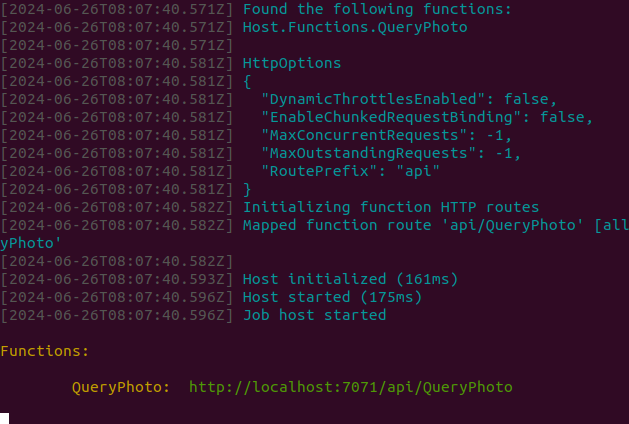

If you open the link, you will see the message:
*Please pass a text query in the request body.*

Passing the query, like http://localhost:7071/api/QueryPhoto?query=%22photo%20with%20flowers%22 should give us the correct response:
*Closest photo id: 3e8626ec-622e-4cb2-b03b-c32ba16966d8, similarity: 0.25130560379172784, query: "photo with flowers".*

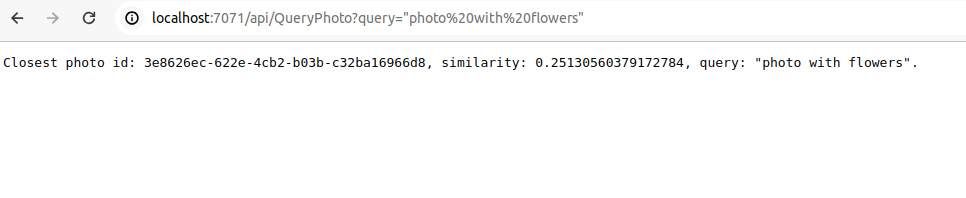

* Deploy the function to Azure. After testing locally, deploy your function to Azure to make it accessible over the internet (refer to the [Azure documentation](https://learn.microsoft.com/en-us/azure/azure-functions/functions-run-local?tabs=linux%2Cisolated-process%2Cnode-v4%2Cpython-v2%2Chttp-trigger%2Ccontainer-apps&pivots=programming-language-python#publish)).

## Backlog

### Cloud Ingestion

* Monitor a local folder for new image uploads and automatically upload new images to Azure Blob Storage when detected.
* Better separate photo upload (raw vs metadata plain vs embeddings).
* Enable Azure Data Lake Storage Gen2 capabilities for the storage account. [See upgrading instructions](https://learn.microsoft.com/en-us/azure/storage/blobs/upgrade-to-data-lake-storage-gen2-how-to?tabs=azure-portal).
* Consider using [Azure Data Factory](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-data-ingest-adf?view=azureml-api-1) for data ingestion. Review alternative solutions for [periodic data tranfer](https://learn.microsoft.com/en-us/azure/storage/common/storage-solution-periodic-data-transfer).

### Data Processing

* Use Azure Function in combination with [Azure Data Factory](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-data-ingest-adf?view=azureml-api-1) for data transformation workflows.
* Use Azure Databricks for large-scale data transformation and processing tasks requiring high performance and scalability.
